In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd

class PINN(nn.Module):
    def __init__(self, layers, beta=0.15, gamma=1/14):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        
        # Define the layers
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        
        # Xavier initialization
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

        self.activation = nn.Tanh()
        self.beta = beta
        self.gamma = gamma
    
    def forward(self, t):
        x = t
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)  # Return a vector [S, I, R]

    def derivatives(self, t):
        # Ensure that t requires gradients
        t.requires_grad = True
        
        # Compute derivatives of S, I, R with respect to t
        s, i, r = self.forward(t).T  # Transpose to unpack
        s_t = autograd.grad(s, t, grad_outputs=torch.ones_like(s), create_graph=True)[0]
        i_t = autograd.grad(i, t, grad_outputs=torch.ones_like(i), create_graph=True)[0]
        r_t = autograd.grad(r, t, grad_outputs=torch.ones_like(r), create_graph=True)[0]
        return s_t, i_t, r_t

# Initial Conditions
S0 = 0.99
I0 = 0.01
R0 = 0.0

# Define the PINN model
layers = [1, 64, 64, 3]  # input, hidden layers, and output (S, I, R)
model = PINN(layers)

# Loss function
def loss_function(t, S0, I0, R0):
    s_t, i_t, r_t = model.derivatives(t)
    
    # SIR equations
    s, i, r = model.forward(t).T
    
    # PDE loss: minimize the residual of the SIR equations
    pde_loss = torch.mean((s_t + model.beta * s * i)**2) + \
                torch.mean((i_t - model.beta * s * i + model.gamma * i)**2) + \
                torch.mean((r_t - model.gamma * i)**2)
    
    # Initial condition loss (scaled)
    init_loss = (s[0] - S0)**2 + \
                (i[0] - I0)**2 + \
                (r[0] - R0)**2
    
    # Scale the initial condition loss to avoid early overfitting to the initial condition
    return pde_loss + 10 * init_loss  # Increase the weight of PDE loss

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Lower learning rate

# Function to generate new collocation points around high-loss regions
def generate_new_points(t, loss_values, num_new_points=10, threshold=1.0):
    """
    Generate new time points where the loss is above the threshold.
    """
    print(t)
    print(loss_values)

    # Find indices where the loss exceeds the threshold
    high_loss_indices = loss_values > threshold
    high_loss_times = t[high_loss_indices]
    
    # If there are high loss regions, sample more points around them
    if high_loss_times.shape[0] > 0:
        new_points = []
        for time in high_loss_times:
            # Generate new points around the high-loss region
            # Ensure we are working with a tensor, not a scalar
            new_times = torch.linspace(max(0, time.item() - 0.1), min(10, time.item() + 0.1), num_new_points).reshape(-1, 1)
            new_points.append(new_times)
        
        # Flatten the list of new points and return
        return torch.cat(new_points).reshape(-1, 1)
    
    return t  # No new points if loss is below threshold

# Training loop
t = torch.linspace(0, 10, 100).reshape(-1, 1)  # Initial time points
for epoch in range(10000):
    optimizer.zero_grad()
    
    # Enable gradient tracking for t
    t = t.requires_grad_()  # Enable gradient tracking for t
    
    # Compute the loss
    loss = loss_function(t, S0, I0, R0)
    
    # Backpropagate
    loss.backward()
    optimizer.step()

    # Calculate loss per point
    loss_values = loss.item()  # Here, we're assuming the loss function returns a single value
    
    # If the loss is high in any region, add new points
    if epoch % 100 == 0:  # Adjust frequency of adding points as needed
        t = generate_new_points(t, loss_values, num_new_points=10, threshold=1.0)
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


tensor([[ 0.0000],
        [ 0.1010],
        [ 0.2020],
        [ 0.3030],
        [ 0.4040],
        [ 0.5051],
        [ 0.6061],
        [ 0.7071],
        [ 0.8081],
        [ 0.9091],
        [ 1.0101],
        [ 1.1111],
        [ 1.2121],
        [ 1.3131],
        [ 1.4141],
        [ 1.5152],
        [ 1.6162],
        [ 1.7172],
        [ 1.8182],
        [ 1.9192],
        [ 2.0202],
        [ 2.1212],
        [ 2.2222],
        [ 2.3232],
        [ 2.4242],
        [ 2.5253],
        [ 2.6263],
        [ 2.7273],
        [ 2.8283],
        [ 2.9293],
        [ 3.0303],
        [ 3.1313],
        [ 3.2323],
        [ 3.3333],
        [ 3.4343],
        [ 3.5354],
        [ 3.6364],
        [ 3.7374],
        [ 3.8384],
        [ 3.9394],
        [ 4.0404],
        [ 4.1414],
        [ 4.2424],
        [ 4.3434],
        [ 4.4444],
        [ 4.5455],
        [ 4.6465],
        [ 4.7475],
        [ 4.8485],
        [ 4.9495],
        [ 5.0505],
        [ 5.1515],
        [ 5.

RuntimeError: a Tensor with 100 elements cannot be converted to Scalar

In [2]:
# Solve using odeint
def solve_ode():
    import numpy as np
    from scipy.integrate import odeint

    # SIR model
    def sir(y, t, beta, gamma):
        S, I, R = y
        dSdt = -beta * S * I
        dIdt = beta * S * I - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt

    # Initial condition
    y0 = [0.99, 0.01, 0]

    # Time points
    t = np.linspace(0, 100, 1000)

    # Parameters
    beta = 0.15
    gamma = 1/14

    # Solve ODE
    sol = odeint(sir, y0, t, args=(beta, gamma))
    return sol

sol = solve_ode()

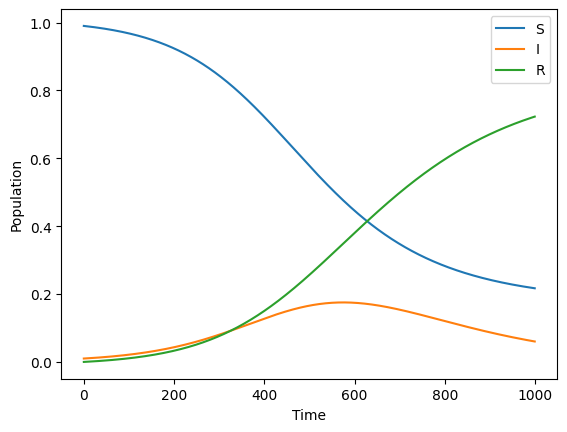

In [3]:
# Plot the solution
import matplotlib.pyplot as plt
plt.plot(sol)
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend(['S', 'I', 'R'])
plt.show()

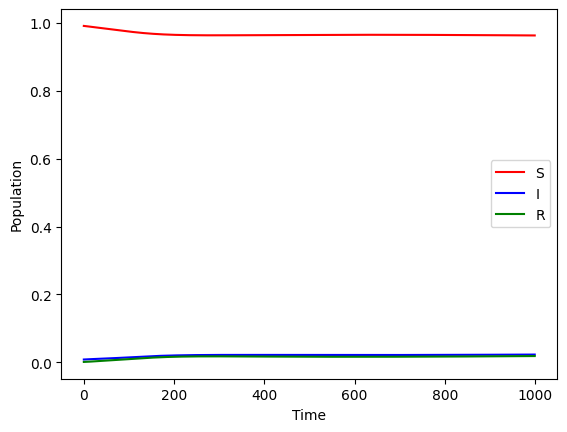

In [ ]:
# Plot the PINN solution
t = torch.linspace(0, 100, 1000).reshape(-1, 1)
s, i, r = model.forward(t).detach().T
plt.plot(s, 'r', label='S')
plt.plot(i, 'b', label='I')
plt.plot(r, 'g', label='R')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

In [5]:
# Check loss of solution
loss = loss_function(t, S0, I0, R0)
print(f'Final Loss: {loss.item()}')

Final Loss: 0.0011587983462959528
